In [1]:
# Data Loader
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
from pytorch_lightning.utilities.types import EVAL_DATALOADERS, TRAIN_DATALOADERS
import pytorch_lightning as pl
import torch.nn.functional as F
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from tqdm import tqdm
from torch.utils.data import random_split
import json
from CustomDataset import * 
import sys
sys.path.append('../')
from config import *
from file_helper import *

def collate_fn(batch):
    return tuple(zip(*batch))
#=================================
#             Augmentation
#=================================

def gauss_noise_tensor(img):
    rand = torch.rand(1)[0]
    if rand < 0.5 and Horizon_AUG:
        sigma = rand *0.125
        out = img + sigma * torch.randn_like(img)
        return out
    return img

def blank(img):    
    return img

class CustomDataModule(pl.LightningDataModule):
    def __init__(self ,
                 train_dir ,
                 test_dir , batch_size = 2, num_workers = 0 , img_size=[IMG_WIDTH, IMG_HEIGHT] , use_aug = True ,padding_count = 24 ,c =0.1
                   ):
        super().__init__()
        self.train_dir = train_dir
        self.test_dir = test_dir
        
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.img_size = img_size      
        self.use_aug = use_aug
        self.padding_count  = padding_count
        self.c = c
        

        pass

    def prepare_data(self) -> None:
        # Download dataset
        pass

    def setup(self, stage):
        # Create dataset...          
                
        self.entire_dataset = CustomDataset(self.train_dir  , use_aug= self.use_aug , padding_count= self.padding_count , c=self.c)
        self.train_ds , self.val_ds = random_split(self.entire_dataset , [0.9, 0.1])        
        self.test_ds = CustomDataset(self.test_dir  , use_aug= False)
        
        pass

    # ToDo: Reture Dataloader...
    def train_dataloader(self) -> TRAIN_DATALOADERS:
        return DataLoader(self.train_ds , batch_size= self.batch_size , num_workers= self.num_workers , shuffle=True)
    
    def val_dataloader(self) -> EVAL_DATALOADERS:
        return DataLoader(self.val_ds , batch_size= self.batch_size , num_workers= self.num_workers , shuffle=False)
    
    def test_dataloader(self) -> EVAL_DATALOADERS:
        return DataLoader(self.test_ds , batch_size= self.batch_size , num_workers= self.num_workers , shuffle=False)

    pass


# Test
dm = CustomDataModule ( train_dir= f"../anno/test_visiable_10_no_cross.json" ,
                       test_dir= f"../anno/test_visiable_10_no_cross.json" , padding_count=256
                       )

d:\conda\envs\layout\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


d:\Projects\Layout\NTHU_CGV_Layout_exp\ours
d:\Projects\Layout\NTHU_CGV_Layout_exp\Horizon_and_SAM\Horizon


In [2]:
from torch import Tensor
def unpad_data( x :[Tensor] ) :
	non_zero_indices = torch.nonzero(x)
	#print(non_zero_indices)
	# Get the non-zero values
	non_zero_values = x[non_zero_indices[:,0], non_zero_indices[:,1]]

	unique = torch.unique(non_zero_indices[:,0] ,return_counts=True)	
	non_zero_values = torch.split(non_zero_values , tuple(unique[1]))
	
	return non_zero_values

Using 16bit None Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3060') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type               | Params
------------------------------------------------------------
0 | backbone             | Resnet             | 23.5 M
1 | fixed_pe             | PositionalEncoding | 0     
2 | transformer          | TransformerModel   | 28.5 M
3 | reduce_height_module | GlobalHeightStage  | 45.5 M
--------------------------------------------------------

Sanity Checking: 0it [00:00, ?it/s]

val!!!!!


Training: 0it [00:00, ?it/s]

pe torch.Size([256, 1, 1024])
out torch.Size([5, 20, 1024])
pred box tensor([[ 0.1334, -0.1666,  0.2280, -0.0520,  0.3760, -0.3789],
        [ 0.0471,  0.1214,  0.3721,  0.6973,  0.3113,  0.4541]],
       device='cuda:0', dtype=torch.float16, grad_fn=<IndexBackward0>)
gt box tensor([[0.4204, 0.1186, 0.2442, 1.0783, 0.1064, 0.3936],
        [0.7810, 0.1661, 0.3079, 1.1682, 0.2308, 0.2692]], device='cuda:0')
L1 loss tensor(0.3617, device='cuda:0', grad_fn=<MeanBackward0>)
cls_loss tensor(0.7307, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
pred box tensor([[ 0.1783, -0.3708,  0.0793,  0.3877,  0.2048,  0.2046]],
       device='cuda:0', dtype=torch.float16, grad_fn=<IndexBackward0>)
gt box tensor([[0.2281, 0.2764, 0.4058, 1.4165, 0.3916, 0.1084]], device='cuda:0')
L1 loss tensor(0.3892, device='cuda:0', grad_fn=<MeanBackward0>)
cls_loss tensor(0.7879, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
pred box tensor([[-0.0154,  0.5166, -0

Validation: 0it [00:00, ?it/s]

val!!!!!


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


pe torch.Size([256, 1, 1024])
out torch.Size([5, 20, 1024])
pred box tensor([[-0.0719,  0.3081,  0.1836, -0.3047,  0.2803,  0.4626],
        [ 0.0978,  0.2289, -0.1500, -0.1052, -0.5703, -0.4165]],
       device='cuda:0', dtype=torch.float16, grad_fn=<IndexBackward0>)
gt box tensor([[0.1490, 0.1182, 0.2947, 1.0324, 0.1730, 0.3270],
        [0.4750, 0.2057, 0.3376, 1.0550, 0.1349, 0.3651]], device='cuda:0')
L1 loss tensor(0.4697, device='cuda:0', grad_fn=<MeanBackward0>)
cls_loss tensor(0.4481, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


pred box tensor([[ 0.2727,  0.2062,  0.3674,  0.4656,  0.0598,  0.4934],
        [ 0.0070,  0.0315,  0.1108, -0.1569,  0.1050,  0.4617],
        [ 0.8433,  0.4924,  0.3562,  1.2383, -0.1376,  0.0696]],
       device='cuda:0', dtype=torch.float16, grad_fn=<IndexBackward0>)
gt box tensor([[0.1115, 0.2178, 0.3592, 1.2010, 0.2194, 0.2806],
        [0.4548, 0.0462, 0.1089, 1.0251, 0.0456, 0.4544],
        [0.5332, 0.0455, 0.0960, 1.0178, 0.0426, 0.4574]], device='cuda:0')
L1 loss tensor(0.2671, device='cuda:0', grad_fn=<MeanBackward0>)
cls_loss tensor(0.4863, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


pred box tensor([[ 0.2267, -0.0149,  0.4126,  0.7637,  0.2103,  0.3438]],
       device='cuda:0', dtype=torch.float16, grad_fn=<IndexBackward0>)
gt box tensor([[0.3680, 0.2120, 0.3495, 1.1741, 0.2038, 0.2962]], device='cuda:0')
L1 loss tensor(0.1493, device='cuda:0', grad_fn=<MeanBackward0>)
cls_loss tensor(0.4001, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


pred box tensor([[ 0.5054, -0.0319, -0.3445,  0.9468, -0.1827, -0.0034]],
       device='cuda:0', dtype=torch.float16, grad_fn=<IndexBackward0>)
gt box tensor([[0.1958, 0.2666, 0.3761, 1.2138, 0.2734, 0.2266]], device='cuda:0')
L1 loss tensor(0.3803, device='cuda:0', grad_fn=<MeanBackward0>)
cls_loss tensor(0.3864, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


pred box tensor([[0.3638, 0.6108, 0.4570, 0.7676, 0.2629, 0.7969]], device='cuda:0',
       dtype=torch.float16, grad_fn=<IndexBackward0>)
gt box tensor([[0.2281, 0.2764, 0.4058, 1.4165, 0.3916, 0.1084]], device='cuda:0')
L1 loss tensor(0.3312, device='cuda:0', grad_fn=<MeanBackward0>)
cls_loss tensor(0.3925, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


pe torch.Size([256, 1, 1024])
out torch.Size([5, 20, 1024])
pred box tensor([[ 0.3201, -0.1489,  0.3027, -0.3066,  0.3997,  0.4915],
        [ 0.3550, -0.0865, -0.2463,  0.0931, -0.2408,  0.1609]],
       device='cuda:0', dtype=torch.float16, grad_fn=<IndexBackward0>)
gt box tensor([[0.1490, 0.1182, 0.2947, 1.0324, 0.1730, 0.3270],
        [0.4750, 0.2057, 0.3376, 1.0550, 0.1349, 0.3651]], device='cuda:0')
L1 loss tensor(0.3929, device='cuda:0', grad_fn=<MeanBackward0>)
cls_loss tensor(0.4641, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


pred box tensor([[ 0.1993,  0.3574,  0.1797,  0.4849, -0.1849,  0.7119],
        [ 0.1008, -0.0073, -0.0355,  0.0139, -0.2922,  0.3213],
        [ 0.6680,  0.2827,  0.3936,  1.1260, -0.0667,  0.1426]],
       device='cuda:0', dtype=torch.float16, grad_fn=<IndexBackward0>)
gt box tensor([[0.1115, 0.2178, 0.3592, 1.2010, 0.2194, 0.2806],
        [0.4548, 0.0462, 0.1089, 1.0251, 0.0456, 0.4544],
        [0.5332, 0.0455, 0.0960, 1.0178, 0.0426, 0.4574]], device='cuda:0')
L1 loss tensor(0.2886, device='cuda:0', grad_fn=<MeanBackward0>)
cls_loss tensor(0.4832, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


pred box tensor([[ 0.2815,  0.2104,  0.1927,  1.0625, -0.1853, -0.2839]],
       device='cuda:0', dtype=torch.float16, grad_fn=<IndexBackward0>)
gt box tensor([[0.3680, 0.2120, 0.3495, 1.1741, 0.2038, 0.2962]], device='cuda:0')
L1 loss tensor(0.2209, device='cuda:0', grad_fn=<MeanBackward0>)
cls_loss tensor(0.3921, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


pred box tensor([[0.5063, 0.6289, 0.0299, 1.0898, 0.2949, 0.4111]], device='cuda:0',
       dtype=torch.float16, grad_fn=<IndexBackward0>)
gt box tensor([[0.1958, 0.2666, 0.3761, 1.2138, 0.2734, 0.2266]], device='cuda:0')
L1 loss tensor(0.2248, device='cuda:0', grad_fn=<MeanBackward0>)
cls_loss tensor(0.3672, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


pred box tensor([[0.0369, 0.6489, 0.0619, 1.2070, 0.4097, 0.2737]], device='cuda:0',
       dtype=torch.float16, grad_fn=<IndexBackward0>)
gt box tensor([[0.2281, 0.2764, 0.4058, 1.4165, 0.3916, 0.1084]], device='cuda:0')
L1 loss tensor(0.2168, device='cuda:0', grad_fn=<MeanBackward0>)
cls_loss tensor(0.3905, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


pe torch.Size([256, 1, 1024])
out torch.Size([5, 20, 1024])
pred box tensor([[ 0.3423,  0.5400, -0.2839,  0.5815, -0.3621,  0.4763],
        [ 0.4221,  0.5244,  0.4326,  0.8247,  0.2279,  0.3418]],
       device='cuda:0', dtype=torch.float16, grad_fn=<IndexBackward0>)
gt box tensor([[0.1490, 0.1182, 0.2947, 1.0324, 0.1730, 0.3270],
        [0.4750, 0.2057, 0.3376, 1.0550, 0.1349, 0.3651]], device='cuda:0')
L1 loss tensor(0.2619, device='cuda:0', grad_fn=<MeanBackward0>)
cls_loss tensor(0.4047, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


pred box tensor([[ 0.1130,  0.0782,  0.1993,  1.2256,  0.2235,  0.2927],
        [ 0.3057,  0.2333,  0.3555,  0.4294,  0.3367,  0.8867],
        [ 0.5728,  0.2073,  0.4780,  0.8599, -0.0914,  0.0357]],
       device='cuda:0', dtype=torch.float16, grad_fn=<IndexBackward0>)
gt box tensor([[0.1115, 0.2178, 0.3592, 1.2010, 0.2194, 0.2806],
        [0.4548, 0.0462, 0.1089, 1.0251, 0.0456, 0.4544],
        [0.5332, 0.0455, 0.0960, 1.0178, 0.0426, 0.4574]], device='cuda:0')
L1 loss tensor(0.1967, device='cuda:0', grad_fn=<MeanBackward0>)
cls_loss tensor(0.4296, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


pred box tensor([[ 0.2715, -0.3528,  0.2371,  0.7485, -0.0454, -0.1482]],
       device='cuda:0', dtype=torch.float16, grad_fn=<IndexBackward0>)
gt box tensor([[0.3680, 0.2120, 0.3495, 1.1741, 0.2038, 0.2962]], device='cuda:0')
L1 loss tensor(0.3155, device='cuda:0', grad_fn=<MeanBackward0>)
cls_loss tensor(0.3864, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


pred box tensor([[-0.0497,  0.4404, -0.3401,  0.4924, -0.5894,  0.3767]],
       device='cuda:0', dtype=torch.float16, grad_fn=<IndexBackward0>)
gt box tensor([[0.1958, 0.2666, 0.3761, 1.2138, 0.2734, 0.2266]], device='cuda:0')
L1 loss tensor(0.4783, device='cuda:0', grad_fn=<MeanBackward0>)
cls_loss tensor(0.3473, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


pred box tensor([[-0.0402,  0.3728, -0.0589,  0.7373,  0.3650, -0.0869]],
       device='cuda:0', dtype=torch.float16, grad_fn=<IndexBackward0>)
gt box tensor([[0.2281, 0.2764, 0.4058, 1.4165, 0.3916, 0.1084]], device='cuda:0')
L1 loss tensor(0.2884, device='cuda:0', grad_fn=<MeanBackward0>)
cls_loss tensor(0.3221, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
pe torch.Size([256, 1, 1024])
out torch.Size([5, 20, 1024])
pred box tensor([[2.4445e-02, 3.6890e-01, 7.4463e-02, 7.9346e-01, 3.7500e-01, 1.5020e-04]],
       device='cuda:0', dtype=torch.float16, grad_fn=<IndexBackward0>)
gt box tensor([[0.4027, 0.2103, 0.3449, 1.1816, 0.2168, 0.2832]], device='cuda:0')
L1 loss tensor(0.2728, device='cuda:0', grad_fn=<MeanBackward0>)
cls_loss tensor(0.3203, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
pred box tensor([[ 0.2463,  0.3887,  0.2778,  0.4548,  0.0867, -0.0583]],
       device='cuda:0', dtype=torch.float16, grad_fn=<IndexBackward0

Validation: 0it [00:00, ?it/s]

val!!!!!
pe torch.Size([256, 1, 1024])
out torch.Size([2, 20, 1024])
u_id tensor([], device='cuda:0', size=(0, 1), dtype=torch.int64)
u_id tensor([], device='cuda:0', size=(0, 1), dtype=torch.int64)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


pe torch.Size([256, 1, 1024])
out torch.Size([5, 20, 1024])
pred box tensor([[-0.4822,  0.2942,  0.3918,  1.2207,  0.8291,  0.5903],
        [ 1.1631, -0.0164,  0.4641,  1.4873,  0.2258,  0.5479]],
       device='cuda:0', dtype=torch.float16, grad_fn=<IndexBackward0>)
gt box tensor([[0.4204, 0.1186, 0.2442, 1.0783, 0.1064, 0.3936],
        [0.7810, 0.1661, 0.3079, 1.1682, 0.2308, 0.2692]], device='cuda:0')
L1 loss tensor(0.3009, device='cuda:0', grad_fn=<MeanBackward0>)
cls_loss tensor(0.3012, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


pred box tensor([[ 0.0205,  0.2161, -0.0981,  2.1328,  0.3323, -0.2712]],
       device='cuda:0', dtype=torch.float16, grad_fn=<IndexBackward0>)
gt box tensor([[0.2245, 0.2259, 0.2487, 1.6404, 0.2829, 0.2171]], device='cuda:0')
L1 loss tensor(0.2652, device='cuda:0', grad_fn=<MeanBackward0>)
cls_loss tensor(0.2619, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


pred box tensor([[0.0565, 0.4480, 0.2642, 1.4482, 0.8887, 0.2316]], device='cuda:0',
       dtype=torch.float16, grad_fn=<IndexBackward0>)
gt box tensor([[0.2281, 0.2764, 0.4058, 1.4165, 0.3916, 0.1084]], device='cuda:0')
L1 loss tensor(0.1895, device='cuda:0', grad_fn=<MeanBackward0>)
cls_loss tensor(0.2284, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


pred box tensor([[ 0.0443,  0.2467, -0.0131,  1.2998, -0.4297,  0.0037],
        [ 0.8896,  0.0477,  0.0037,  0.8926, -0.0423,  0.6870]],
       device='cuda:0', dtype=torch.float16, grad_fn=<IndexBackward0>)
gt box tensor([[0.1493, 0.1651, 0.2973, 1.1207, 0.1574, 0.3426],
        [0.6557, 0.1765, 0.3131, 1.1246, 0.1627, 0.3373]], device='cuda:0')
L1 loss tensor(0.2551, device='cuda:0', grad_fn=<MeanBackward0>)
cls_loss tensor(0.3124, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


pred box tensor([[0.1281, 0.3987, 0.4475, 1.0234, 0.2727, 0.1093]], device='cuda:0',
       dtype=torch.float16, grad_fn=<IndexBackward0>)
gt box tensor([[0.4044, 0.2728, 0.3878, 1.1952, 0.2509, 0.2491]], device='cuda:0')
L1 loss tensor(0.1326, device='cuda:0', grad_fn=<MeanBackward0>)
cls_loss tensor(0.2954, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


pe torch.Size([256, 1, 1024])
out torch.Size([5, 20, 1024])
pred box tensor([[ 0.4800,  0.0804, -0.1879,  0.8589,  0.1176,  0.4136],
        [ 0.8149,  0.1004,  0.3835,  1.0664,  0.4241,  0.6016]],
       device='cuda:0', dtype=torch.float16, grad_fn=<IndexBackward0>)
gt box tensor([[0.4204, 0.1186, 0.2442, 1.0783, 0.1064, 0.3936],
        [0.7810, 0.1661, 0.3079, 1.1682, 0.2308, 0.2692]], device='cuda:0')
L1 loss tensor(0.1319, device='cuda:0', grad_fn=<MeanBackward0>)
cls_loss tensor(0.3251, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


pred box tensor([[ 0.0649,  0.6802,  0.0717,  2.0918,  0.1250, -0.2029]],
       device='cuda:0', dtype=torch.float16, grad_fn=<IndexBackward0>)
gt box tensor([[0.2245, 0.2259, 0.2487, 1.6404, 0.2829, 0.2171]], device='cuda:0')
L1 loss tensor(0.3034, device='cuda:0', grad_fn=<MeanBackward0>)
cls_loss tensor(0.2554, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


pred box tensor([[0.3752, 0.4846, 0.3547, 1.2119, 0.9487, 0.0059]], device='cuda:0',
       dtype=torch.float16, grad_fn=<IndexBackward0>)
gt box tensor([[0.2281, 0.2764, 0.4058, 1.4165, 0.3916, 0.1084]], device='cuda:0')
L1 loss tensor(0.2118, device='cuda:0', grad_fn=<MeanBackward0>)
cls_loss tensor(0.2410, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


pred box tensor([[-0.0327,  0.1002, -0.0383,  1.2764, -0.0952,  0.0210],
        [ 0.9878,  0.3101, -0.3533,  1.2861, -0.0185,  0.8101]],
       device='cuda:0', dtype=torch.float16, grad_fn=<IndexBackward0>)
gt box tensor([[0.1493, 0.1651, 0.2973, 1.1207, 0.1574, 0.3426],
        [0.6557, 0.1765, 0.3131, 1.1246, 0.1627, 0.3373]], device='cuda:0')
L1 loss tensor(0.2717, device='cuda:0', grad_fn=<MeanBackward0>)
cls_loss tensor(0.2782, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


pred box tensor([[ 0.2656, -0.0101,  0.4390,  1.1514,  0.1920,  0.2283]],
       device='cuda:0', dtype=torch.float16, grad_fn=<IndexBackward0>)
gt box tensor([[0.4044, 0.2728, 0.3878, 1.1952, 0.2509, 0.2491]], device='cuda:0')
L1 loss tensor(0.0994, device='cuda:0', grad_fn=<MeanBackward0>)
cls_loss tensor(0.3133, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


pe torch.Size([256, 1, 1024])
out torch.Size([5, 20, 1024])
pred box tensor([[-0.2729,  0.1727,  0.3330,  1.0723,  1.0400,  0.4912],
        [ 1.0127,  0.1035,  0.0181,  1.7168,  0.1631,  0.5098]],
       device='cuda:0', dtype=torch.float16, grad_fn=<IndexBackward0>)
gt box tensor([[0.4204, 0.1186, 0.2442, 1.0783, 0.1064, 0.3936],
        [0.7810, 0.1661, 0.3079, 1.1682, 0.2308, 0.2692]], device='cuda:0')
L1 loss tensor(0.2762, device='cuda:0', grad_fn=<MeanBackward0>)
cls_loss tensor(0.3084, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


pred box tensor([[0.5811, 0.2905, 0.5596, 1.4355, 0.6094, 0.5786]], device='cuda:0',
       dtype=torch.float16, grad_fn=<IndexBackward0>)
gt box tensor([[0.2245, 0.2259, 0.2487, 1.6404, 0.2829, 0.2171]], device='cuda:0')
L1 loss tensor(0.2708, device='cuda:0', grad_fn=<MeanBackward0>)
cls_loss tensor(0.2398, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


pred box tensor([[ 0.1486, -0.0402,  0.6919,  1.5928,  0.5483,  0.3774]],
       device='cuda:0', dtype=torch.float16, grad_fn=<IndexBackward0>)
gt box tensor([[0.2281, 0.2764, 0.4058, 1.4165, 0.3916, 0.1084]], device='cuda:0')
L1 loss tensor(0.2140, device='cuda:0', grad_fn=<MeanBackward0>)
cls_loss tensor(0.2498, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


pred box tensor([[0.3342, 0.4751, 0.1698, 1.1328, 0.1293, 0.3496],
        [0.8545, 0.1200, 0.0324, 0.7295, 0.1092, 0.7212]], device='cuda:0',
       dtype=torch.float16, grad_fn=<IndexBackward0>)
gt box tensor([[0.1493, 0.1651, 0.2973, 1.1207, 0.1574, 0.3426],
        [0.6557, 0.1765, 0.3131, 1.1246, 0.1627, 0.3373]], device='cuda:0')
L1 loss tensor(0.1699, device='cuda:0', grad_fn=<MeanBackward0>)
cls_loss tensor(0.2948, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


pred box tensor([[0.2925, 0.4116, 0.2507, 0.0867, 0.1140, 0.0914]], device='cuda:0',
       dtype=torch.float16, grad_fn=<IndexBackward0>)
gt box tensor([[0.4044, 0.2728, 0.3878, 1.1952, 0.2509, 0.2491]], device='cuda:0')
L1 loss tensor(0.2985, device='cuda:0', grad_fn=<MeanBackward0>)
cls_loss tensor(0.3585, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
pe torch.Size([256, 1, 1024])
out torch.Size([5, 20, 1024])
pred box tensor([[ 0.4902, -0.1475,  0.4365,  0.9907,  0.2812,  0.3228],
        [ 0.8022,  0.1708,  0.7036,  0.7568, -0.3171,  0.5698]],
       device='cuda:0', dtype=torch.float16, grad_fn=<IndexBackward0>)
gt box tensor([[0.3826, 0.3011, 0.3989, 1.2701, 0.3105, 0.1895],
        [0.7501, 0.0925, 0.1955, 1.0457, 0.0903, 0.4097]], device='cuda:0')
L1 loss tensor(0.2109, device='cuda:0', grad_fn=<MeanBackward0>)
cls_loss tensor(0.4037, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
pred box tensor([[0.2267, 0.3582, 0.5767, 0.

Validation: 0it [00:00, ?it/s]

val!!!!!
pe torch.Size([256, 1, 1024])
out torch.Size([2, 20, 1024])
u_id tensor([], device='cuda:0', size=(0, 1), dtype=torch.int64)
u_id tensor([], device='cuda:0', size=(0, 1), dtype=torch.int64)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


pe torch.Size([256, 1, 1024])
out torch.Size([5, 20, 1024])
pred box tensor([[ 0.1608, -0.1506,  0.2004,  0.7998,  0.0183,  0.3386],
        [ 0.2705,  0.2539,  0.4087,  0.6626,  0.1302,  0.2107],
        [ 0.5811, -0.2415,  0.7324,  1.0273,  0.2659,  0.2720]],
       device='cuda:0', dtype=torch.float16, grad_fn=<IndexBackward0>)
gt box tensor([[0.1683, 0.0356, 0.0880, 1.0171, 0.0397, 0.4603],
        [0.2933, 0.0578, 0.1301, 1.0302, 0.0576, 0.4424],
        [0.4349, 0.2201, 0.3403, 1.1524, 0.2694, 0.2306]], device='cuda:0')
L1 loss tensor(0.1670, device='cuda:0', grad_fn=<MeanBackward0>)
cls_loss tensor(0.3011, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


pred box tensor([[ 0.0535,  0.2683,  0.5312,  1.2021,  0.7695,  0.5439],
        [ 0.5439,  0.3086, -0.0038,  1.0586,  0.0630, -0.1837]],
       device='cuda:0', dtype=torch.float16, grad_fn=<IndexBackward0>)
gt box tensor([[0.4204, 0.1186, 0.2442, 1.0783, 0.1064, 0.3936],
        [0.7810, 0.1661, 0.3079, 1.1682, 0.2308, 0.2692]], device='cuda:0')
L1 loss tensor(0.2635, device='cuda:0', grad_fn=<MeanBackward0>)
cls_loss tensor(0.3267, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


pred box tensor([[ 0.5117, -0.0637,  0.6216,  0.3152,  0.6221,  0.1858]],
       device='cuda:0', dtype=torch.float16, grad_fn=<IndexBackward0>)
gt box tensor([[0.4027, 0.2103, 0.3449, 1.1816, 0.2168, 0.2832]], device='cuda:0')
L1 loss tensor(0.3381, device='cuda:0', grad_fn=<MeanBackward0>)
cls_loss tensor(0.2020, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


pred box tensor([[ 0.4609, -0.4597, -0.4441,  1.1240,  0.0568,  0.9482]],
       device='cuda:0', dtype=torch.float16, grad_fn=<IndexBackward0>)
gt box tensor([[0.5182, 0.0377, 0.0875, 1.0144, 0.0389, 0.4611]], device='cuda:0')
L1 loss tensor(0.2835, device='cuda:0', grad_fn=<MeanBackward0>)
cls_loss tensor(0.1645, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


pred box tensor([[ 0.0618, -0.1978,  0.0861,  0.9854,  0.0211,  0.3083],
        [ 0.3665,  0.2073,  0.2646,  1.4150,  0.4194,  0.1980],
        [ 0.3186,  0.0677,  0.2295,  0.7974,  0.2384,  0.1703],
        [ 0.4719, -0.1869, -0.2141,  1.1143,  0.2786,  0.3279]],
       device='cuda:0', dtype=torch.float16, grad_fn=<IndexBackward0>)
gt box tensor([[0.2345, 0.0566, 0.1372, 1.0328, 0.0657, 0.4343],
        [0.4439, 0.0699, 0.1548, 1.0274, 0.0617, 0.4383],
        [0.5016, 0.0647, 0.1492, 1.0329, 0.0728, 0.4272],
        [0.6360, 0.0875, 0.1761, 1.0393, 0.0810, 0.4190]], device='cuda:0')
L1 loss tensor(0.1718, device='cuda:0', grad_fn=<MeanBackward0>)
cls_loss tensor(0.3449, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


pe torch.Size([256, 1, 1024])
out torch.Size([5, 20, 1024])
pred box tensor([[ 0.2329, -0.1660,  0.0872,  1.0176,  0.1758,  0.4490],
        [ 0.2502,  0.0146,  0.2686,  1.4990,  0.4126,  0.4854],
        [ 0.5527, -0.1832,  0.8076,  1.1992,  0.0513,  0.2759]],
       device='cuda:0', dtype=torch.float16, grad_fn=<IndexBackward0>)
gt box tensor([[0.1683, 0.0356, 0.0880, 1.0171, 0.0397, 0.4603],
        [0.2933, 0.0578, 0.1301, 1.0302, 0.0576, 0.4424],
        [0.4349, 0.2201, 0.3403, 1.1524, 0.2694, 0.2306]], device='cuda:0')
L1 loss tensor(0.1558, device='cuda:0', grad_fn=<MeanBackward0>)
cls_loss tensor(0.2947, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


pred box tensor([[ 0.2444,  0.0287,  0.1383,  1.1279,  0.3127,  0.2238],
        [ 0.4065,  0.0872, -0.1005,  0.9766, -0.0872, -0.1575]],
       device='cuda:0', dtype=torch.float16, grad_fn=<IndexBackward0>)
gt box tensor([[0.4204, 0.1186, 0.2442, 1.0783, 0.1064, 0.3936],
        [0.7810, 0.1661, 0.3079, 1.1682, 0.2308, 0.2692]], device='cuda:0')
L1 loss tensor(0.2163, device='cuda:0', grad_fn=<MeanBackward0>)
cls_loss tensor(0.3338, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


pred box tensor([[0.3125, 0.1331, 0.5601, 1.4453, 0.2463, 0.2883]], device='cuda:0',
       dtype=torch.float16, grad_fn=<IndexBackward0>)
gt box tensor([[0.4027, 0.2103, 0.3449, 1.1816, 0.2168, 0.2832]], device='cuda:0')
L1 loss tensor(0.1135, device='cuda:0', grad_fn=<MeanBackward0>)
cls_loss tensor(0.2017, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


pred box tensor([[0.3354, 0.0447, 0.7471, 0.7129, 0.4458, 0.4219]], device='cuda:0',
       dtype=torch.float16, grad_fn=<IndexBackward0>)
gt box tensor([[0.5182, 0.0377, 0.0875, 1.0144, 0.0389, 0.4611]], device='cuda:0')
L1 loss tensor(0.2662, device='cuda:0', grad_fn=<MeanBackward0>)
cls_loss tensor(0.2256, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


pred box tensor([[ 0.1094, -0.4060,  0.1028,  1.0000,  0.1148,  0.2974],
        [ 0.5166,  0.1004,  0.1394,  1.2646,  0.5220,  0.4185],
        [ 0.4004,  0.3174,  0.3625,  0.7329,  0.0755,  0.2742],
        [ 0.5254, -0.0977, -0.2927,  0.9443,  0.0792,  0.3098]],
       device='cuda:0', dtype=torch.float16, grad_fn=<IndexBackward0>)
gt box tensor([[0.2345, 0.0566, 0.1372, 1.0328, 0.0657, 0.4343],
        [0.4439, 0.0699, 0.1548, 1.0274, 0.0617, 0.4383],
        [0.5016, 0.0647, 0.1492, 1.0329, 0.0728, 0.4272],
        [0.6360, 0.0875, 0.1761, 1.0393, 0.0810, 0.4190]], device='cuda:0')
L1 loss tensor(0.1529, device='cuda:0', grad_fn=<MeanBackward0>)
cls_loss tensor(0.3490, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


pe torch.Size([256, 1, 1024])
out torch.Size([5, 20, 1024])
pred box tensor([[ 0.1141,  0.1055,  0.2256,  1.1035, -0.3157,  0.6123],
        [ 0.3394,  0.1659,  0.2437,  1.4873,  0.1908,  0.4565],
        [ 0.6523, -0.1775,  0.7114,  1.0850,  0.2688,  0.2505]],
       device='cuda:0', dtype=torch.float16, grad_fn=<IndexBackward0>)
gt box tensor([[0.1683, 0.0356, 0.0880, 1.0171, 0.0397, 0.4603],
        [0.2933, 0.0578, 0.1301, 1.0302, 0.0576, 0.4424],
        [0.4349, 0.2201, 0.3403, 1.1524, 0.2694, 0.2306]], device='cuda:0')
L1 loss tensor(0.1557, device='cuda:0', grad_fn=<MeanBackward0>)
cls_loss tensor(0.2921, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


pred box tensor([[ 0.4580,  0.1464,  0.2094,  1.2432, -0.0602,  0.5312],
        [ 0.6875,  0.4512,  0.1696,  0.9614,  0.3926,  0.1969]],
       device='cuda:0', dtype=torch.float16, grad_fn=<IndexBackward0>)
gt box tensor([[0.4204, 0.1186, 0.2442, 1.0783, 0.1064, 0.3936],
        [0.7810, 0.1661, 0.3079, 1.1682, 0.2308, 0.2692]], device='cuda:0')
L1 loss tensor(0.1272, device='cuda:0', grad_fn=<MeanBackward0>)
cls_loss tensor(0.3144, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


pred box tensor([[ 0.3289, -0.2340,  0.6001,  0.1904,  0.6094,  0.2534]],
       device='cuda:0', dtype=torch.float16, grad_fn=<IndexBackward0>)
gt box tensor([[0.4027, 0.2103, 0.3449, 1.1816, 0.2168, 0.2832]], device='cuda:0')
L1 loss tensor(0.3645, device='cuda:0', grad_fn=<MeanBackward0>)
cls_loss tensor(0.2122, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


pred box tensor([[ 0.9873, -0.6572,  0.5054,  1.0352,  0.1434,  0.5063]],
       device='cuda:0', dtype=torch.float16, grad_fn=<IndexBackward0>)
gt box tensor([[0.5182, 0.0377, 0.0875, 1.0144, 0.0389, 0.4611]], device='cuda:0')
L1 loss tensor(0.2921, device='cuda:0', grad_fn=<MeanBackward0>)
cls_loss tensor(0.2124, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


pred box tensor([[ 0.2827, -0.2556,  0.2708,  0.8374,  0.0837,  0.3145],
        [ 0.4668, -0.1321,  0.3865,  1.3125,  0.4312,  0.3242],
        [ 0.6279,  0.0616,  0.0271,  0.9448,  0.1169,  0.0105],
        [ 0.7236, -0.1772,  0.1060,  1.0830,  0.3533,  0.3271]],
       device='cuda:0', dtype=torch.float16, grad_fn=<IndexBackward0>)
gt box tensor([[0.2345, 0.0566, 0.1372, 1.0328, 0.0657, 0.4343],
        [0.4439, 0.0699, 0.1548, 1.0274, 0.0617, 0.4383],
        [0.5016, 0.0647, 0.1492, 1.0329, 0.0728, 0.4272],
        [0.6360, 0.0875, 0.1761, 1.0393, 0.0810, 0.4190]], device='cuda:0')
L1 loss tensor(0.1535, device='cuda:0', grad_fn=<MeanBackward0>)
cls_loss tensor(0.3340, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
pe torch.Size([256, 1, 1024])
out torch.Size([5, 20, 1024])
pred box tensor([[0.8848, 0.8428, 0.6514, 1.9961, 0.7354, 0.2458]], device='cuda:0',
       dtype=torch.float16, grad_fn=<IndexBackward0>)
gt box tensor([[0.2281, 0.2764, 0.4058, 1.416

Validation: 0it [00:00, ?it/s]

val!!!!!
pe torch.Size([256, 1, 1024])
out torch.Size([2, 20, 1024])
u_id tensor([], device='cuda:0', size=(0, 1), dtype=torch.int64)
u_id tensor([], device='cuda:0', size=(0, 1), dtype=torch.int64)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


pe torch.Size([256, 1, 1024])
out torch.Size([5, 20, 1024])
pred box tensor([[ 0.4150,  0.0054, -0.1143,  1.1084,  0.0526,  0.0474],
        [ 0.5835,  0.0042, -0.2717,  1.0049,  0.1335,  0.4597]],
       device='cuda:0', dtype=torch.float16, grad_fn=<IndexBackward0>)
gt box tensor([[0.3734, 0.0475, 0.1094, 1.0176, 0.0541, 0.4459],
        [0.7547, 0.0373, 0.0916, 1.0602, 0.0364, 0.4636]], device='cuda:0')
L1 loss tensor(0.1268, device='cuda:0', grad_fn=<MeanBackward0>)
cls_loss tensor(0.2590, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


pred box tensor([[ 0.2500,  0.1060, -0.0994,  1.3086,  0.0384,  0.0733],
        [ 0.6069,  0.1030,  0.7188,  1.0771,  0.1815,  0.3635],
        [ 0.7192, -0.0735, -0.0433,  0.9863, -0.0779,  0.5190],
        [ 0.8169, -0.0037,  0.0625,  1.1768,  0.2563,  0.5806]],
       device='cuda:0', dtype=torch.float16, grad_fn=<IndexBackward0>)
gt box tensor([[0.2345, 0.0566, 0.1372, 1.0328, 0.0657, 0.4343],
        [0.4439, 0.0699, 0.1548, 1.0274, 0.0617, 0.4383],
        [0.5016, 0.0647, 0.1492, 1.0329, 0.0728, 0.4272],
        [0.6360, 0.0875, 0.1761, 1.0393, 0.0810, 0.4190]], device='cuda:0')
L1 loss tensor(0.1528, device='cuda:0', grad_fn=<MeanBackward0>)
cls_loss tensor(0.3782, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


pred box tensor([[0.8394, 0.1120, 0.4575, 0.4832, 0.3689, 0.2408]], device='cuda:0',
       dtype=torch.float16, grad_fn=<IndexBackward0>)
gt box tensor([[0.1958, 0.2666, 0.3761, 1.2138, 0.2734, 0.2266]], device='cuda:0')
L1 loss tensor(0.2867, device='cuda:0', grad_fn=<MeanBackward0>)
cls_loss tensor(0.2572, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


pred box tensor([[ 0.4355,  0.0986,  0.2295,  1.4541,  0.3511,  0.1516],
        [ 0.9678, -0.0761, -0.1027,  1.2139, -0.1989,  0.1371]],
       device='cuda:0', dtype=torch.float16, grad_fn=<IndexBackward0>)
gt box tensor([[0.1493, 0.1651, 0.2973, 1.1207, 0.1574, 0.3426],
        [0.6557, 0.1765, 0.3131, 1.1246, 0.1627, 0.3373]], device='cuda:0')
L1 loss tensor(0.2308, device='cuda:0', grad_fn=<MeanBackward0>)
cls_loss tensor(0.2113, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


pred box tensor([[ 0.2810,  0.3418,  0.1334,  1.3701,  0.5933, -0.0821],
        [ 1.0469,  0.1306,  0.0720,  1.3164, -0.1009,  0.3284]],
       device='cuda:0', dtype=torch.float16, grad_fn=<IndexBackward0>)
gt box tensor([[0.3826, 0.3011, 0.3989, 1.2701, 0.3105, 0.1895],
        [0.7501, 0.0925, 0.1955, 1.0457, 0.0903, 0.4097]], device='cuda:0')
L1 loss tensor(0.1720, device='cuda:0', grad_fn=<MeanBackward0>)
cls_loss tensor(0.2600, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


pe torch.Size([256, 1, 1024])
out torch.Size([5, 20, 1024])
pred box tensor([[ 0.2052,  0.2015, -0.1504,  1.3281,  0.3225,  0.1190],
        [ 0.7725, -0.1250, -0.1094,  0.9058,  0.2803,  0.3494]],
       device='cuda:0', dtype=torch.float16, grad_fn=<IndexBackward0>)
gt box tensor([[0.3734, 0.0475, 0.1094, 1.0176, 0.0541, 0.4459],
        [0.7547, 0.0373, 0.0916, 1.0602, 0.0364, 0.4636]], device='cuda:0')
L1 loss tensor(0.1984, device='cuda:0', grad_fn=<MeanBackward0>)
cls_loss tensor(0.2500, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


pred box tensor([[ 0.2961, -0.0087,  0.1125,  0.8994, -0.1545,  0.3992],
        [ 0.4023, -0.2622,  0.6089,  1.2129,  0.2629,  0.7026],
        [ 0.8286,  0.0660,  0.2100,  0.9414, -0.1672,  0.5156],
        [ 0.3967,  0.0687,  0.1001,  1.0703, -0.3142,  0.1404]],
       device='cuda:0', dtype=torch.float16, grad_fn=<IndexBackward0>)
gt box tensor([[0.2345, 0.0566, 0.1372, 1.0328, 0.0657, 0.4343],
        [0.4439, 0.0699, 0.1548, 1.0274, 0.0617, 0.4383],
        [0.5016, 0.0647, 0.1492, 1.0329, 0.0728, 0.4272],
        [0.6360, 0.0875, 0.1761, 1.0393, 0.0810, 0.4190]], device='cuda:0')
L1 loss tensor(0.1611, device='cuda:0', grad_fn=<MeanBackward0>)
cls_loss tensor(0.4222, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


pred box tensor([[0.6636, 0.2544, 0.1816, 0.3040, 0.6045, 0.0649]], device='cuda:0',
       dtype=torch.float16, grad_fn=<IndexBackward0>)
gt box tensor([[0.1958, 0.2666, 0.3761, 1.2138, 0.2734, 0.2266]], device='cuda:0')
L1 loss tensor(0.3462, device='cuda:0', grad_fn=<MeanBackward0>)
cls_loss tensor(0.2543, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


pred box tensor([[ 0.2474,  0.3047,  0.1881,  1.3330,  0.2568, -0.1145],
        [ 0.8462, -0.0243,  0.2688,  1.1025,  0.0299,  0.3943]],
       device='cuda:0', dtype=torch.float16, grad_fn=<IndexBackward0>)
gt box tensor([[0.1493, 0.1651, 0.2973, 1.1207, 0.1574, 0.3426],
        [0.6557, 0.1765, 0.3131, 1.1246, 0.1627, 0.3373]], device='cuda:0')
L1 loss tensor(0.1469, device='cuda:0', grad_fn=<MeanBackward0>)
cls_loss tensor(0.2080, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


pred box tensor([[ 0.4021,  0.1591,  0.2517,  1.4043,  0.3840, -0.0852],
        [ 0.6382,  0.2842,  0.4668,  1.7139,  0.5654,  0.2360]],
       device='cuda:0', dtype=torch.float16, grad_fn=<IndexBackward0>)
gt box tensor([[0.3826, 0.3011, 0.3989, 1.2701, 0.3105, 0.1895],
        [0.7501, 0.0925, 0.1955, 1.0457, 0.0903, 0.4097]], device='cuda:0')
L1 loss tensor(0.2236, device='cuda:0', grad_fn=<MeanBackward0>)
cls_loss tensor(0.3249, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


pe torch.Size([256, 1, 1024])
out torch.Size([5, 20, 1024])
pred box tensor([[ 0.1764, -0.0200, -0.1078,  1.1367,  0.3787,  0.1285],
        [ 0.8726,  0.0638, -0.0554,  1.1309,  0.2009,  0.2725]],
       device='cuda:0', dtype=torch.float16, grad_fn=<IndexBackward0>)
gt box tensor([[0.3734, 0.0475, 0.1094, 1.0176, 0.0541, 0.4459],
        [0.7547, 0.0373, 0.0916, 1.0602, 0.0364, 0.4636]], device='cuda:0')
L1 loss tensor(0.1634, device='cuda:0', grad_fn=<MeanBackward0>)
cls_loss tensor(0.2199, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


pred box tensor([[ 0.0177,  0.0462,  0.1694,  0.9121, -0.0418,  0.0219],
        [ 0.4412,  0.0140,  0.5498,  0.9219, -0.1099,  0.6016],
        [ 0.6392, -0.0781,  0.2480,  1.0889,  0.1753,  0.3899],
        [ 0.8281,  0.2681, -0.0456,  1.1270,  0.2452,  0.5459]],
       device='cuda:0', dtype=torch.float16, grad_fn=<IndexBackward0>)
gt box tensor([[0.2345, 0.0566, 0.1372, 1.0328, 0.0657, 0.4343],
        [0.4439, 0.0699, 0.1548, 1.0274, 0.0617, 0.4383],
        [0.5016, 0.0647, 0.1492, 1.0329, 0.0728, 0.4272],
        [0.6360, 0.0875, 0.1761, 1.0393, 0.0810, 0.4190]], device='cuda:0')
L1 loss tensor(0.1393, device='cuda:0', grad_fn=<MeanBackward0>)
cls_loss tensor(0.3558, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


pred box tensor([[0.5830, 0.3284, 0.4812, 0.7974, 0.2175, 0.0693]], device='cuda:0',
       dtype=torch.float16, grad_fn=<IndexBackward0>)
gt box tensor([[0.1958, 0.2666, 0.3761, 1.2138, 0.2734, 0.2266]], device='cuda:0')
L1 loss tensor(0.1973, device='cuda:0', grad_fn=<MeanBackward0>)
cls_loss tensor(0.2479, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


pred box tensor([[ 0.0915,  0.4023,  0.3523,  1.4590,  0.0432,  0.1545],
        [ 0.3684,  0.1355,  0.3196,  1.1182,  0.0511, -0.1184]],
       device='cuda:0', dtype=torch.float16, grad_fn=<IndexBackward0>)
gt box tensor([[0.1493, 0.1651, 0.2973, 1.1207, 0.1574, 0.3426],
        [0.6557, 0.1765, 0.3131, 1.1246, 0.1627, 0.3373]], device='cuda:0')
L1 loss tensor(0.1583, device='cuda:0', grad_fn=<MeanBackward0>)
cls_loss tensor(0.2021, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


pred box tensor([[-0.0313,  0.2649,  0.1141,  1.5117,  0.3218, -0.1567],
        [ 0.9976,  0.3438,  0.2286,  1.5332,  0.3669,  0.2634]],
       device='cuda:0', dtype=torch.float16, grad_fn=<IndexBackward0>)
gt box tensor([[0.3826, 0.3011, 0.3989, 1.2701, 0.3105, 0.1895],
        [0.7501, 0.0925, 0.1955, 1.0457, 0.0903, 0.4097]], device='cuda:0')
L1 loss tensor(0.2314, device='cuda:0', grad_fn=<MeanBackward0>)
cls_loss tensor(0.2833, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
pe torch.Size([256, 1, 1024])
out torch.Size([5, 20, 1024])
pred box tensor([[ 0.5386,  0.0562,  0.4302,  0.2971, -0.5278,  0.2664]],
       device='cuda:0', dtype=torch.float16, grad_fn=<IndexBackward0>)
gt box tensor([[0.4840, 0.1777, 0.3129, 1.1109, 0.1399, 0.3601]], device='cuda:0')
L1 loss tensor(0.3114, device='cuda:0', grad_fn=<MeanBackward0>)
cls_loss tensor(0.2207, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
pred box tensor([[ 0.4509,  0.1847,  0

Validation: 0it [00:00, ?it/s]

val!!!!!
pe torch.Size([256, 1, 1024])
out torch.Size([2, 20, 1024])
u_id tensor([], device='cuda:0', size=(0, 1), dtype=torch.int64)
u_id tensor([], device='cuda:0', size=(0, 1), dtype=torch.int64)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


pe torch.Size([256, 1, 1024])
out torch.Size([5, 20, 1024])
pred box tensor([[ 0.3079, -0.0384, -0.1407,  0.9585,  0.0575,  0.6724],
        [ 0.9541,  0.1359,  0.1989,  1.3740, -0.2019,  0.2306]],
       device='cuda:0', dtype=torch.float16, grad_fn=<IndexBackward0>)
gt box tensor([[0.3734, 0.0475, 0.1094, 1.0176, 0.0541, 0.4459],
        [0.7547, 0.0373, 0.0916, 1.0602, 0.0364, 0.4636]], device='cuda:0')
L1 loss tensor(0.1567, device='cuda:0', grad_fn=<MeanBackward0>)
cls_loss tensor(0.2816, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
pred box tensor([[ 0.1124,  0.0774, -0.2615,  1.5459,  0.0894,  0.4854]],
       device='cuda:0', dtype=torch.float16, grad_fn=<IndexBackward0>)
gt box tensor([[0.4027, 0.2103, 0.3449, 1.1816, 0.2168, 0.2832]], device='cuda:0')
L1 loss tensor(0.2873, device='cuda:0', grad_fn=<MeanBackward0>)
cls_loss tensor(0.1284, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


pred box tensor([[-0.2290,  0.2115,  0.5972,  1.7344,  0.2230,  0.5312]],
       device='cuda:0', dtype=torch.float16, grad_fn=<IndexBackward0>)
gt box tensor([[0.4022, 0.2515, 0.3723, 1.1840, 0.2579, 0.2421]], device='cuda:0')
L1 loss tensor(0.2951, device='cuda:0', grad_fn=<MeanBackward0>)
cls_loss tensor(0.1760, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


pred box tensor([[ 0.5386,  0.8086, -0.1385,  1.6182,  0.8306,  0.7930]],
       device='cuda:0', dtype=torch.float16, grad_fn=<IndexBackward0>)
gt box tensor([[0.2245, 0.2259, 0.2487, 1.6404, 0.2829, 0.2171]], device='cuda:0')
L1 loss tensor(0.4050, device='cuda:0', grad_fn=<MeanBackward0>)
cls_loss tensor(0.1523, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


pred box tensor([[-0.0722, -0.0338,  0.6055,  1.0254,  0.1598,  0.3965],
        [ 0.5371,  0.2427,  0.4441,  1.5371,  0.0031, -0.2786]],
       device='cuda:0', dtype=torch.float16, grad_fn=<IndexBackward0>)
gt box tensor([[0.1493, 0.1651, 0.2973, 1.1207, 0.1574, 0.3426],
        [0.6557, 0.1765, 0.3131, 1.1246, 0.1627, 0.3373]], device='cuda:0')
L1 loss tensor(0.1987, device='cuda:0', grad_fn=<MeanBackward0>)
cls_loss tensor(0.1974, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


pe torch.Size([256, 1, 1024])
out torch.Size([5, 20, 1024])
pred box tensor([[ 0.3701,  0.1015, -0.1578,  0.8906, -0.0707,  0.4365],
        [ 1.0127,  0.2878, -0.0189,  1.2354, -0.1072,  0.1683]],
       device='cuda:0', dtype=torch.float16, grad_fn=<IndexBackward0>)
gt box tensor([[0.3734, 0.0475, 0.1094, 1.0176, 0.0541, 0.4459],
        [0.7547, 0.0373, 0.0916, 1.0602, 0.0364, 0.4636]], device='cuda:0')
L1 loss tensor(0.1516, device='cuda:0', grad_fn=<MeanBackward0>)
cls_loss tensor(0.2783, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


pred box tensor([[ 0.1984,  0.0578,  0.1810,  1.5908, -0.0603,  0.5425]],
       device='cuda:0', dtype=torch.float16, grad_fn=<IndexBackward0>)
gt box tensor([[0.4027, 0.2103, 0.3449, 1.1816, 0.2168, 0.2832]], device='cuda:0')
L1 loss tensor(0.2444, device='cuda:0', grad_fn=<MeanBackward0>)
cls_loss tensor(0.1265, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


pred box tensor([[-0.3052,  0.4224,  0.9409,  1.6768,  0.1285,  0.4048]],
       device='cuda:0', dtype=torch.float16, grad_fn=<IndexBackward0>)
gt box tensor([[0.4022, 0.2515, 0.3723, 1.1840, 0.2579, 0.2421]], device='cuda:0')
L1 loss tensor(0.3719, device='cuda:0', grad_fn=<MeanBackward0>)
cls_loss tensor(0.1751, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


pred box tensor([[ 0.6597,  0.5449, -0.1166,  1.5146,  0.6577,  0.4502]],
       device='cuda:0', dtype=torch.float16, grad_fn=<IndexBackward0>)
gt box tensor([[0.2245, 0.2259, 0.2487, 1.6404, 0.2829, 0.2171]], device='cuda:0')
L1 loss tensor(0.3089, device='cuda:0', grad_fn=<MeanBackward0>)
cls_loss tensor(0.1445, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


pred box tensor([[0.2015, 0.2332, 0.3218, 0.6509, 0.0585, 0.4844],
        [0.5308, 0.2366, 0.2969, 0.7373, 0.2805, 0.4368]], device='cuda:0',
       dtype=torch.float16, grad_fn=<IndexBackward0>)
gt box tensor([[0.1493, 0.1651, 0.2973, 1.1207, 0.1574, 0.3426],
        [0.6557, 0.1765, 0.3131, 1.1246, 0.1627, 0.3373]], device='cuda:0')
L1 loss tensor(0.1384, device='cuda:0', grad_fn=<MeanBackward0>)
cls_loss tensor(0.3516, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


pe torch.Size([256, 1, 1024])
out torch.Size([5, 20, 1024])
pred box tensor([[ 0.5581, -0.0430, -0.0969,  1.2578, -0.2874,  0.7754],
        [ 0.7910, -0.0222, -0.0278,  1.0059,  0.0491,  0.4729]],
       device='cuda:0', dtype=torch.float16, grad_fn=<IndexBackward0>)
gt box tensor([[0.3734, 0.0475, 0.1094, 1.0176, 0.0541, 0.4459],
        [0.7547, 0.0373, 0.0916, 1.0602, 0.0364, 0.4636]], device='cuda:0')
L1 loss tensor(0.1404, device='cuda:0', grad_fn=<MeanBackward0>)
cls_loss tensor(0.2647, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


pred box tensor([[ 0.2603,  0.2316, -0.1276,  1.2441,  0.1207,  0.5898]],
       device='cuda:0', dtype=torch.float16, grad_fn=<IndexBackward0>)
gt box tensor([[0.4027, 0.2103, 0.3449, 1.1816, 0.2168, 0.2832]], device='cuda:0')
L1 loss tensor(0.1836, device='cuda:0', grad_fn=<MeanBackward0>)
cls_loss tensor(0.1179, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


pred box tensor([[-0.0625,  0.2590,  0.7300,  1.3506,  0.2032,  0.2515]],
       device='cuda:0', dtype=torch.float16, grad_fn=<IndexBackward0>)
gt box tensor([[0.4022, 0.2515, 0.3723, 1.1840, 0.2579, 0.2421]], device='cuda:0')
L1 loss tensor(0.1768, device='cuda:0', grad_fn=<MeanBackward0>)
cls_loss tensor(0.1731, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


pred box tensor([[ 0.4785,  0.5298, -0.0283,  1.7783,  0.4407,  0.4487]],
       device='cuda:0', dtype=torch.float16, grad_fn=<IndexBackward0>)
gt box tensor([[0.2245, 0.2259, 0.2487, 1.6404, 0.2829, 0.2171]], device='cuda:0')
L1 loss tensor(0.2270, device='cuda:0', grad_fn=<MeanBackward0>)
cls_loss tensor(0.1425, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


pred box tensor([[ 0.0975,  0.0051,  0.2539,  0.5142,  0.0591,  0.1700],
        [ 0.6655,  0.3037,  0.6123,  1.6143, -0.0807, -0.0137]],
       device='cuda:0', dtype=torch.float16, grad_fn=<IndexBackward0>)
gt box tensor([[0.1493, 0.1651, 0.2973, 1.1207, 0.1574, 0.3426],
        [0.6557, 0.1765, 0.3131, 1.1246, 0.1627, 0.3373]], device='cuda:0')
L1 loss tensor(0.2211, device='cuda:0', grad_fn=<MeanBackward0>)
cls_loss tensor(0.2352, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
pe torch.Size([256, 1, 1024])
out torch.Size([5, 20, 1024])
pred box tensor([[ 0.5791,  0.3677,  0.1505,  0.8086, -0.0531, -0.2551]],
       device='cuda:0', dtype=torch.float16, grad_fn=<IndexBackward0>)
gt box tensor([[0.4044, 0.2728, 0.3878, 1.1952, 0.2509, 0.2491]], device='cuda:0')
L1 loss tensor(0.2836, device='cuda:0', grad_fn=<MeanBackward0>)
cls_loss tensor(0.1796, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
pred box tensor([[0.6812, 0.3364, 0.62

Validation: 0it [00:00, ?it/s]

val!!!!!
pe torch.Size([256, 1, 1024])
out torch.Size([2, 20, 1024])
u_id tensor([], device='cuda:0', size=(0, 1), dtype=torch.int64)
u_id tensor([], device='cuda:0', size=(0, 1), dtype=torch.int64)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


pe torch.Size([256, 1, 1024])
out torch.Size([5, 20, 1024])
pred box tensor([[0.0511, 0.1836, 0.1791, 1.2549, 0.3694, 0.1438]], device='cuda:0',
       dtype=torch.float16, grad_fn=<IndexBackward0>)
gt box tensor([[0.4044, 0.2728, 0.3878, 1.1952, 0.2509, 0.2491]], device='cuda:0')
L1 loss tensor(0.1558, device='cuda:0', grad_fn=<MeanBackward0>)
cls_loss tensor(0.1990, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


pred box tensor([[ 0.2852,  0.2771, -0.0621,  1.7334,  0.3599,  0.0958]],
       device='cuda:0', dtype=torch.float16, grad_fn=<IndexBackward0>)
gt box tensor([[0.2245, 0.2259, 0.2487, 1.6404, 0.2829, 0.2171]], device='cuda:0')
L1 loss tensor(0.1190, device='cuda:0', grad_fn=<MeanBackward0>)
cls_loss tensor(0.1326, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


pred box tensor([[0.0181, 0.2346, 0.4692, 1.2852, 0.3167, 0.0947]], device='cuda:0',
       dtype=torch.float16, grad_fn=<IndexBackward0>)
gt box tensor([[0.1958, 0.2666, 0.3761, 1.2138, 0.2734, 0.2266]], device='cuda:0')
L1 loss tensor(0.0916, device='cuda:0', grad_fn=<MeanBackward0>)
cls_loss tensor(0.2099, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


pred box tensor([[-0.0895, -0.0517,  0.4929,  1.6963, -0.2242, -0.0176]],
       device='cuda:0', dtype=torch.float16, grad_fn=<IndexBackward0>)
gt box tensor([[0.2281, 0.2764, 0.4058, 1.4165, 0.3916, 0.1084]], device='cuda:0')
L1 loss tensor(0.2924, device='cuda:0', grad_fn=<MeanBackward0>)
cls_loss tensor(0.1479, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


pred box tensor([[ 0.0408, -0.2556,  0.4622,  1.3252,  0.3494, -0.0552],
        [ 0.4502, -0.2683,  0.2659,  0.6504, -0.0517,  0.3540],
        [ 0.2479,  0.3850,  0.3069,  1.1309, -0.0653,  0.5811]],
       device='cuda:0', dtype=torch.float16, grad_fn=<IndexBackward0>)
gt box tensor([[0.1115, 0.2178, 0.3592, 1.2010, 0.2194, 0.2806],
        [0.4548, 0.0462, 0.1089, 1.0251, 0.0456, 0.4544],
        [0.5332, 0.0455, 0.0960, 1.0178, 0.0426, 0.4574]], device='cuda:0')
L1 loss tensor(0.1925, device='cuda:0', grad_fn=<MeanBackward0>)
cls_loss tensor(0.5132, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


pe torch.Size([256, 1, 1024])
out torch.Size([5, 20, 1024])
pred box tensor([[-0.0688,  0.0670,  0.1064,  1.1299,  0.5391,  0.3120]],
       device='cuda:0', dtype=torch.float16, grad_fn=<IndexBackward0>)
gt box tensor([[0.4044, 0.2728, 0.3878, 1.1952, 0.2509, 0.2491]], device='cuda:0')
L1 loss tensor(0.2295, device='cuda:0', grad_fn=<MeanBackward0>)
cls_loss tensor(0.1956, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


pred box tensor([[ 0.3247,  0.1244,  0.0341,  1.7695,  0.3818, -0.0197]],
       device='cuda:0', dtype=torch.float16, grad_fn=<IndexBackward0>)
gt box tensor([[0.2245, 0.2259, 0.2487, 1.6404, 0.2829, 0.2171]], device='cuda:0')
L1 loss tensor(0.1469, device='cuda:0', grad_fn=<MeanBackward0>)
cls_loss tensor(0.1468, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


pred box tensor([[-0.1874,  0.2295,  0.3066,  1.3877,  0.0767,  0.0684]],
       device='cuda:0', dtype=torch.float16, grad_fn=<IndexBackward0>)
gt box tensor([[0.1958, 0.2666, 0.3761, 1.2138, 0.2734, 0.2266]], device='cuda:0')
L1 loss tensor(0.1698, device='cuda:0', grad_fn=<MeanBackward0>)
cls_loss tensor(0.2107, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


pred box tensor([[ 0.0296,  0.2593,  0.6982,  1.7012,  0.0393, -0.1145]],
       device='cuda:0', dtype=torch.float16, grad_fn=<IndexBackward0>)
gt box tensor([[0.2281, 0.2764, 0.4058, 1.4165, 0.3916, 0.1084]], device='cuda:0')
L1 loss tensor(0.2280, device='cuda:0', grad_fn=<MeanBackward0>)
cls_loss tensor(0.1507, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


pred box tensor([[ 0.1046, -0.0627,  0.1144,  1.0488, -0.3379,  0.3240],
        [ 0.7373,  0.0453,  0.0131,  1.0791,  0.1592,  0.4570],
        [ 0.5781,  0.1920,  0.3704,  0.8853, -0.0917,  0.7041]],
       device='cuda:0', dtype=torch.float16, grad_fn=<IndexBackward0>)
gt box tensor([[0.1115, 0.2178, 0.3592, 1.2010, 0.2194, 0.2806],
        [0.4548, 0.0462, 0.1089, 1.0251, 0.0456, 0.4544],
        [0.5332, 0.0455, 0.0960, 1.0178, 0.0426, 0.4574]], device='cuda:0')
L1 loss tensor(0.1563, device='cuda:0', grad_fn=<MeanBackward0>)
cls_loss tensor(0.3814, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


pe torch.Size([256, 1, 1024])
out torch.Size([5, 20, 1024])
pred box tensor([[0.0637, 0.1271, 0.2172, 1.3340, 0.4504, 0.2903]], device='cuda:0',
       dtype=torch.float16, grad_fn=<IndexBackward0>)
gt box tensor([[0.4044, 0.2728, 0.3878, 1.1952, 0.2509, 0.2491]], device='cuda:0')
L1 loss tensor(0.1728, device='cuda:0', grad_fn=<MeanBackward0>)
cls_loss tensor(0.2020, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


pred box tensor([[0.0332, 0.0334, 0.0898, 1.4521, 0.0566, 0.3647]], device='cuda:0',
       dtype=torch.float16, grad_fn=<IndexBackward0>)
gt box tensor([[0.2245, 0.2259, 0.2487, 1.6404, 0.2829, 0.2171]], device='cuda:0')
L1 loss tensor(0.1842, device='cuda:0', grad_fn=<MeanBackward0>)
cls_loss tensor(0.1405, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


pred box tensor([[-0.2859,  0.2330,  0.4153,  1.1240,  0.4277,  0.1632]],
       device='cuda:0', dtype=torch.float16, grad_fn=<IndexBackward0>)
gt box tensor([[0.1958, 0.2666, 0.3761, 1.2138, 0.2734, 0.2266]], device='cuda:0')
L1 loss tensor(0.1437, device='cuda:0', grad_fn=<MeanBackward0>)
cls_loss tensor(0.2186, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


pred box tensor([[ 0.0305,  0.1299,  0.3137,  1.7324,  0.1038, -0.0669]],
       device='cuda:0', dtype=torch.float16, grad_fn=<IndexBackward0>)
gt box tensor([[0.2281, 0.2764, 0.4058, 1.4165, 0.3916, 0.1084]], device='cuda:0')
L1 loss tensor(0.2025, device='cuda:0', grad_fn=<MeanBackward0>)
cls_loss tensor(0.1470, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


pred box tensor([[-0.0346, -0.1148,  0.3242,  1.2910, -0.1164,  0.3386],
        [ 0.7227,  0.0674,  0.0978,  1.3799,  0.0948,  0.2949],
        [ 0.2888,  0.0995,  0.3765,  0.8838, -0.0584,  0.2224]],
       device='cuda:0', dtype=torch.float16, grad_fn=<IndexBackward0>)
gt box tensor([[0.1115, 0.2178, 0.3592, 1.2010, 0.2194, 0.2806],
        [0.4548, 0.0462, 0.1089, 1.0251, 0.0456, 0.4544],
        [0.5332, 0.0455, 0.0960, 1.0178, 0.0426, 0.4574]], device='cuda:0')
L1 loss tensor(0.1617, device='cuda:0', grad_fn=<MeanBackward0>)
cls_loss tensor(0.3871, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
pe torch.Size([256, 1, 1024])
out torch.Size([5, 20, 1024])
pred box tensor([[0.0926, 0.0629, 0.0370, 0.8623, 0.3008, 0.3022],
        [0.6157, 0.1203, 0.4590, 0.5356, 0.0642, 0.4368]], device='cuda:0',
       dtype=torch.float16, grad_fn=<IndexBackward0>)
gt box tensor([[0.1493, 0.1651, 0.2973, 1.1207, 0.1574, 0.3426],
        [0.6557, 0.1765, 0.3131, 1.1246, 0.1

Validation: 0it [00:00, ?it/s]

val!!!!!
pe torch.Size([256, 1, 1024])
out torch.Size([2, 20, 1024])
u_id tensor([], device='cuda:0', size=(0, 1), dtype=torch.int64)
u_id tensor([], device='cuda:0', size=(0, 1), dtype=torch.int64)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


pe torch.Size([256, 1, 1024])
out torch.Size([5, 20, 1024])
pred box tensor([[0.5352, 0.2627, 0.3484, 1.3203, 0.1680, 0.4102]], device='cuda:0',
       dtype=torch.float16, grad_fn=<IndexBackward0>)
gt box tensor([[0.2245, 0.2259, 0.2487, 1.6404, 0.2829, 0.2171]], device='cuda:0')
L1 loss tensor(0.1792, device='cuda:0', grad_fn=<MeanBackward0>)
cls_loss tensor(0.1911, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


pred box tensor([[0.2991, 0.3157, 0.5342, 1.0986, 0.2607, 0.3296]], device='cuda:0',
       dtype=torch.float16, grad_fn=<IndexBackward0>)
gt box tensor([[0.5182, 0.0377, 0.0875, 1.0144, 0.0389, 0.4611]], device='cuda:0')
L1 loss tensor(0.2302, device='cuda:0', grad_fn=<MeanBackward0>)
cls_loss tensor(0.2086, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


pred box tensor([[ 0.0621, -0.3020,  0.1494,  0.7773, -0.0563,  0.4529],
        [ 0.3948,  0.1793, -0.2974,  0.9292, -0.0264,  0.2932],
        [-0.1405,  0.0999,  0.1865,  0.9624,  0.3179,  0.6943],
        [ 0.8330,  0.4216,  0.4751,  0.7554,  0.1858,  0.4351]],
       device='cuda:0', dtype=torch.float16, grad_fn=<IndexBackward0>)
gt box tensor([[0.2345, 0.0566, 0.1372, 1.0328, 0.0657, 0.4343],
        [0.4439, 0.0699, 0.1548, 1.0274, 0.0617, 0.4383],
        [0.5016, 0.0647, 0.1492, 1.0329, 0.0728, 0.4272],
        [0.6360, 0.0875, 0.1761, 1.0393, 0.0810, 0.4190]], device='cuda:0')
L1 loss tensor(0.1839, device='cuda:0', grad_fn=<MeanBackward0>)
cls_loss tensor(0.3867, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


pred box tensor([[ 0.4299,  0.3171,  0.2094,  0.7314, -0.0350,  0.2417],
        [ 0.7612,  0.1146,  0.1576,  1.0967,  0.1814,  0.1904]],
       device='cuda:0', dtype=torch.float16, grad_fn=<IndexBackward0>)
gt box tensor([[0.4204, 0.1186, 0.2442, 1.0783, 0.1064, 0.3936],
        [0.7810, 0.1661, 0.3079, 1.1682, 0.2308, 0.2692]], device='cuda:0')
L1 loss tensor(0.1087, device='cuda:0', grad_fn=<MeanBackward0>)
cls_loss tensor(0.2439, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


pred box tensor([[0.4424, 0.2808, 0.0938, 0.9067, 0.2148, 0.3594]], device='cuda:0',
       dtype=torch.float16, grad_fn=<IndexBackward0>)
gt box tensor([[0.4027, 0.2103, 0.3449, 1.1816, 0.2168, 0.2832]], device='cuda:0')
L1 loss tensor(0.1190, device='cuda:0', grad_fn=<MeanBackward0>)
cls_loss tensor(0.0920, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


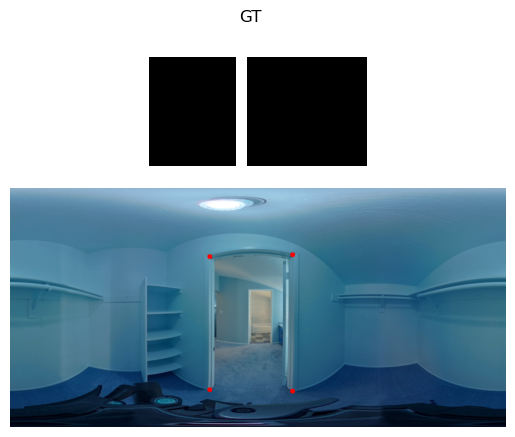

In [11]:
import torch
from torch import nn
from torch.nn import functional as F
from typing import Any
import pytorch_lightning as pl
from config import *
import torchvision.models as models
from torchvision.ops import MLP
import math
from torch import Tensor
from torch.nn import TransformerEncoder, TransformerEncoderLayer
import matplotlib.pyplot as plt
from scipy.optimize import linear_sum_assignment
from VerticalCompressionNet import * 
from CustomTransformer import *

def encode_target(box_b):
    box_b[:, 1] = torch.abs(0.5 -box_b[:, 1])  # v top
    box_b[:, 2] = torch.abs(box_b[:, 2] -0.5) # v btm
    box_b[:, 3] = torch.exp(torch.abs(box_b[:, 3] - box_b[:, 0] ))# du

    box_b[:, 4] = torch.abs(0.5 -box_b[:, 4])  # v top
    box_b[:, 5] = torch.abs(box_b[:, 4] -0.5) # v btm
    box_b[:, 0] = box_b[:, 0]   # u
    '''
    box_b[:, 1] = torch.exp(torch.abs(0.5 -box_b[:, 1]))  # v top
    box_b[:, 2] = torch.exp(torch.abs(box_b[:, 2] -0.5)) # v btm
    box_b[:, 3] = torch.exp(torch.abs(box_b[:, 3])) # du

    box_b[:, 4] = torch.exp(torch.abs(0.5 -box_b[:, 4]))  # v top
    box_b[:, 5] = torch.exp(torch.abs(box_b[:, 4] -0.5)) # v btm
    box_b[:, 0] = torch.exp( box_b[:, 0] )  # u
    '''

    return box_b
def decode_target(box_b):
    box_b[:, 0] = box_b[:, 0]  # u
    box_b[:, 1] = 0.5 - box_b[:, 1]  # v top
    box_b[:, 2] = box_b[:, 2] +0.5 # v btm
    box_b[:, 3] = box_b[:, 0] + torch.log(box_b[:, 3])  # du

    box_b[:, 4] = 0.5 -box_b[:, 4]  # v top    
    box_b[:, 5] = box_b[:, 4] +0.5 # v btm
    '''
    box_b[:, 0] = torch.log( box_b[:, 0] )  # u
    box_b[:, 1] = 0.5 - torch.log(box_b[:, 1])  # v top
    box_b[:, 2] = torch.log(box_b[:, 2]) +0.5 # v btm
    box_b[:, 3] = torch.log(box_b[:, 3]) + box_b[:, 0] # du

    box_b[:, 4] = 0.5 - torch.log(box_b[:, 4])  # v top    
    box_b[:, 5] = torch.log(box_b[:, 4]) +0.5 # v btm
    '''
    return box_b

class PositionalEncoding(nn.Module):
    def __init__(self, d_model: 256, dropout: float = 0.1, max_len: int = 1024):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        r"""Inputs of forward function
        Args:
            x: the sequence fed to the positional encoder model (required).
        Shape:
            x: [sequence length, batch size, embed dim]
            output: [sequence length, batch size, embed dim]
        Examples:
            >>> output = pos_encoder(x)
        """
        print("pe" , self.pe.shape)
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)


class TransformerModel(nn.Module):
    def __init__(self, d_model: 256, nhead: int , d_hid: int, nlayers: int, dropout: float = 0.1 , activation="relu" ,
                  normalize_before=False , out_dim=20 ,channel = 1024):
        super().__init__()
        #self.ntoken = ntoken
        self.model_type = 'Transformer'
        self.d_model = d_model
        self.out_dim =out_dim
        
        self.pe = PositionalEncoding(1024 ,dropout , max_len= d_model)
        #self.query_embed = nn.Embedding(out_dim, d_model)

        encoder_layer = TransformerEncoderLayer(1024, nhead, d_hid,
                                                dropout, activation, normalize_before)
        encoder_norm = nn.LayerNorm(1024) if normalize_before else None
        self.encoder = TransformerEncoder(encoder_layer, nlayers, encoder_norm)
        '''
       
        self.decoder = nn.Linear(out_dim, d_model)
        decoder_layer = nn.TransformerDecoderLayer(d_model=256, nhead=8  )
        self.decoder = nn.TransformerDecoder(decoder_layer, num_layers=6)

        self.decoder1 = nn.Conv1d(d_model , d_model//2 , kernel_size=3 , padding=1)
        self.decoder2 = nn.Conv1d(d_model//2 , d_model//4 , kernel_size=1)
        self.decoder3 = nn.Conv1d(d_model//4, self.out_dim , kernel_size=1)
        #self.mlp = torchvision.ops.mlp(,)
        '''
        self.enc_proj = nn.Linear(channel , self.out_dim * 4)
        
        self.cls_head = nn.Linear(channel, 1 )
        self.box_head = nn.Linear(channel, 6 )
    
        
    def forward(self, src: Tensor ) -> Tensor:
        # permute to (Sequence_length , Batches , Hidden layer)
        '''
        plt.imshow(src[0].detach().cpu().numpy())
        plt.title("src")
        plt.show()
        '''
        src         = src.permute(2,0,1)   #  [w, b, c*h]  , example: [256 , 5 , 1024]        
        #src         = src.permute(1 , 0 , 2)# torch.Size([1024, b, 256])        
        batch_size  = src.shape[1]   
        '''
        '''     
        src_pe         = self.pe(src)   # [ 256 , b , hidden_dim]
        #print("src_pe",src_pe.shape)
        src_pe         = self.encoder(src_pe) # [ 256 , b , hidden_dim]
        #src_pe         = src_pe.permute(1,0,2)  # [b , width , 1024]
        out = src_pe.permute(1 , 2 , 0, 3)  # [b, max_count , seq_len, step_cols]
        out = out.contiguous().view(out.shape[0] , self.out_dim , -1) 
        print("out",out.shape)

        #print(src_pe.shape)
        #plt.imshow(src_pe[0].detach().cpu().numpy())
        #plt.title("encoder output")
        #plt.show()
        #print("self.query_embed.weight " , self.query_embed.weight .shape)
        #out = self.decoder( self.query_embed.weight , src_pe)
        '''
        out = self.decoder1(src_pe)        
        out = torch.relu(out)
        out = self.decoder2(out)        
        out = torch.relu(out)
        out = self.decoder3(out)        
        out = torch.relu(out)
        '''
        #print("out",src_pe.shape)        
       
        box_u_logits = self.u_head(out)
        box_v_logits = self.v_head(out)
        cls_logits = self.cls_head(out)
        
        #print("box_v_logits" , box_v_logits.shape)
        box_logits = torch.cat([ box_u_logits[:,:,0].unsqueeze(2) ,
                                 box_v_logits[:,:,0].unsqueeze(2) ,
                                 box_v_logits[:,:,1].unsqueeze(2) , 
                                 box_u_logits[:,:,1].unsqueeze(2) ,
                                 box_v_logits[:,:,2].unsqueeze(2) ,
                                 box_v_logits[:,:,3].unsqueeze(2)] , dim=-1 )
        #print("box_logits" , box_logits.shape)
        return box_logits ,cls_logits



    

class VerticalQueryTransformer(pl.LightningModule):    
    def __init__(self  ,  max_predict_count = 24 ,
                    hidden_out = 128 , class_num = 1 ,
                    log_folder = "__test" , num_classes = 1 , backbone_trainable =False, load_weight ="" , top_k = 20 
                    ):
        #print(" input_size" ,  input_size)
        super().__init__()
        self.backbone = Resnet()
        self.out_scale = 8
        self.step_cols = 4        
        self.hidden_size = hidden_out
        self.max_predict_count = max_predict_count
        self.num_classes  = num_classes 
        self.top_k_num = top_k        

        self.fixed_pe = PositionalEncoding(hidden_out, 0.1 , 1024)

        self.transformer = TransformerModel( d_model=hidden_out , nhead=8 , d_hid= 256,nlayers=6 ,out_dim=max_predict_count)
        #self.transformer = nn.TransformerEncoderLayer(hidden_out ,  8 , 2048 , dropout= 0.1) 

        self.confidence_threshold = 0.75

        # loss
        self.box_cost = 1
        self.cls_cost = 5

        self.log_folder = create_folder(os.path.join(os.getcwd() , "output" , log_folder))

        self.automatic_optimization = False

        # Inference channels number from each block of the encoder
        with torch.no_grad():
            dummy = torch.zeros(1, 3, 320, 190)
            c1, c2, c3, c4 = [b.shape[1] for b in self.backbone(dummy)] # resnet feature channel數
            #print("c1, c2, c3, c4" , c1, c2, c3, c4)
            c_last = (c1*8 + c2*4 + c3*2 + c4*1) // self.out_scale            
        #self.v_reproj = nn.Conv2d(1024 , self.max_predict_count,kernel_size=1)
            
        self.reduce_height_module = GlobalHeightStage(c1, c2, c3, c4 , out_scale=self.out_scale , pretrain_weight= load_weight , freeze_model= not backbone_trainable)

    def post_process(self ,box_coord , index , max_length = 1024):
        '''
        box_coord : contains left top v ,left btm v , du , right top v , right btm v
        '''
        origin_shape = box_coord.shape
        box_coord = box_coord.view(-1 , 5)
        
        us = (index/max_length).view((box_coord.shape[0] , 1))
        uvv_uvv_b = torch.zeros((box_coord.shape[0] , 6) , device=box_coord.device)
        uvv_uvv_b[:,0] = us[:,0]
        uvv_uvv_b[:,1] = box_coord[:,0] # left top v
        uvv_uvv_b[:,2] = box_coord[:,1] # left btm v
        uvv_uvv_b[:,3] = us[:,0] + box_coord[:,2] # right u
        uvv_uvv_b[:,4] = box_coord[:,3] # right top v
        uvv_uvv_b[:,5] = box_coord[:,4] # right btm v

        #return uvv_uvv_b.view(origin_shape[0] , origin_shape[1] , 6)
        return uvv_uvv_b.view(origin_shape[0] , -1 , 6)

        pass

    def forward(self ,x ):
        features = self.backbone(x) # [4 , c , h, w]              
        # vertical feature
        reduced_feats  = self.reduce_height_module(features , x.shape[3]//self.step_cols ) # [b , 1024 ,  256] width = 1024 , 256d latent code each.
        #plt.imshow(reduced_feats[0].detach().cpu().numpy())
        #plt.title("reduced_feats")
        #plt.show()

        out_box , out_cls = self.transformer(reduced_feats)  # (b , 1024 , 256 )               

        return out_box , out_cls
    
    @torch.no_grad()
    def inf(self , imgs ):
        
        out_box , out_cls   = self.forward(imgs)  # [ batch , top_k , 5]   , [ batch , top_k , 1]         
        #print("val " , out_cls)
        #print("val sigmoid" , torch.sigmoid(out_cls))
        
        batch_size = out_box.shape[0]
        #sampled_u_idx = torch.argwhere( torch.sigmoid(out_cls.view(batch_size , -1)) > 0.01 )
        #print("sampled_u_idx" , sampled_u_idx)

        sampled_box_b = []
        #each batch
        for img , pred , pcls in zip(imgs, out_box , out_cls.view(batch_size,-1)):  
            u_id = torch.argwhere(torch.sigmoid(pcls) > self.confidence_threshold)
            print("u_id"  , u_id)
            if(u_id.numel() ==0):
                continue
            u_id = u_id.view(-1)            
            
            #pred = self.post_process(pbox[u_id,:] , u_id ).view(-1,6)
            pred = pred[u_id]
            
            save_folder = create_folder( os.path.join(self.log_folder ,"val"))
            save_path = os.path.join(save_folder, f"val_ep_{self.current_epoch}-{self.global_step}" )

            decode_pred = decode_target(pred.clone())
            #pred_us , pred_tops , pred_btms = self.pack_visualize(pred[:,0], pred[:,1],pred[:,2],pred[:,3] -pred[:,0] ,pred[:,4],pred[:,5] )                    
            pred_us , pred_tops , pred_btms = self.pack_visualize(decode_pred[:,0], decode_pred[:,1],decode_pred[:,2],decode_pred[:,3] ,decode_pred[:,4],decode_pred[:,5] )                    
            vis_imgs = visualize_2d_single(pred_us , pred_tops , pred_btms , u_grad = F.sigmoid(pcls).view(1 , -1 ) , imgs=  img , title="Pred" , save_path= save_path  )
            #plt.imshow(vis_imgs)
            #plt.show()

            # ToDo: calculate loss          
        
    @torch.no_grad()
    def pack_visualize(self, gt_u_b , gt_vtop_b , gt_vbtm_b , gt_du_b , gt_dvtop_b , dv_btm_b ):
        
        if isinstance(gt_u_b, torch.Tensor):
            sizes = [t.numel() for t in gt_u_b]               
            us = gt_u_b.flatten().unsqueeze(0).repeat(2, 1).permute(1,0).reshape(-1)
            us[1::2]+=gt_du_b.flatten()
            us = torch.split(us.view(-1,2) , sizes)

            tops = gt_vtop_b.flatten().unsqueeze(0).repeat(2, 1).permute(1,0).reshape(-1)
            tops[1::2]=gt_dvtop_b.flatten()
            tops = torch.split(tops.view(-1,2) , sizes)

            btms = gt_vbtm_b.flatten().unsqueeze(0).repeat(2, 1).permute(1,0).reshape(-1)
            btms[1::2]=dv_btm_b.flatten()
            btms = torch.split(btms.view(-1,2) , sizes)

        elif isinstance(gt_u_b, tuple) and all(isinstance(t, torch.Tensor) for t in gt_u_b):        
            sizes = [len(t) for t in gt_u_b]               
            us = torch.cat(gt_u_b).view(-1).unsqueeze(0).repeat(2, 1).permute(1,0).reshape(-1)
            us[1::2]+=torch.cat(gt_du_b).view(-1)
            us = torch.split(us.view(-1,2) , sizes)

            tops = torch.cat(gt_vtop_b).view(-1).unsqueeze(0).repeat(2, 1).permute(1,0).reshape(-1)
            tops[1::2]=torch.cat(gt_dvtop_b).view(-1)
            tops = torch.split(tops.view(-1,2) , sizes)

            btms = torch.cat(gt_vbtm_b).view(-1).unsqueeze(0).repeat(2, 1).permute(1,0).reshape(-1)
            btms[1::2]=torch.cat(dv_btm_b).view(-1)
            btms = torch.split(btms.view(-1,2) , sizes)
        else:
            assert("Wrong Type.")
        
        return us , tops ,btms
        
        pass

    def training_step(self , input_b ,batch_idx ):
        
        img = input_b['image']        
        out_box , out_cls   = self.forward(img)  # [ batch , top_k , 5]   , [ batch , top_k , 1] 
        #print("max out_cls" , torch.max(out_cls) , "min " , torch.min(out_cls))
        batch_size = out_box.shape[0]
        
        '''
        if self.current_epoch % 5 == 0 :#and self.current_epoch > 0 :       
            plt.imshow(out_cls[0].repeat(1,100).detach().cpu().numpy())
            plt.title("encoder cls output")
            plt.show()      
        '''

        # Select top k        
        #top_k = torch.topk(out_cls ,self.top_k_num , dim= 1 )
        #top_k_idx = top_k[1].view(batch_size  , self.top_k_num)  # [b , top_k ]        
        #print("top_k_idx" , top_k_idx.shape , top_k_idx)

        #topk_box = out_box.gather(1 , top_k_idx.unsqueeze(-1).repeat(1,1,5))
        #topk_cls = out_cls.gather(1 , top_k_idx.unsqueeze(-1).repeat(1,1,1))
        #print("topk_cls" , topk_cls.shape)
        
        #pred_uvvboxes_b = self.post_process(topk_box , top_k_idx )
        #pred_uvvboxes_b = self.post_process(out_box , out_box )
        #print("pred_uvvboxes_b" , pred_uvvboxes_b.shape ,pred_uvvboxes_b)

        # remove padding , each batch have different length
        gt_u_b = unpad_data( input_b['u'])          
        gt_vtop_b =unpad_data(input_b['v_top'])
        gt_vbtm_b = unpad_data (input_b['v_btm'])
        gt_du_b = unpad_data(input_b['du'])
        gt_dvtop_b = unpad_data(input_b['dv_top'])
        gt_dv_btm_b = unpad_data(input_b['dv_btm'])
        
        total_loss = 0
        b_cnt = 0        
        
        for u,vtop,vbtm,du,dvtop, dvbtm , pred ,cls_b  in zip(gt_u_b , gt_vtop_b , gt_vbtm_b , gt_du_b , gt_dvtop_b , gt_dv_btm_b , out_box , out_cls  ):
            
            # match                        
            gt_box =  torch.vstack([ u, vtop,vbtm, u + du ,dvtop , dvbtm]).permute(1,0)   # [n , 6]
            #print("gt_box" , gt_box)
            gt_l1_target = encode_target(gt_box.clone())           

            
            u_cost = torch.cdist( (torch.arange(self.max_predict_count,device=u.device).unsqueeze(-1) /self.max_predict_count ) , u.unsqueeze(-1) )            
            #u_cost = torch.cdist( pred[:,0].unsqueeze(-1) , u.unsqueeze(-1) )
            box_loss = torch.cdist( pred , gt_l1_target , p=1)
            cls_cost = -torch.sigmoid(cls_b)
            cost_matrix = box_loss * self.box_cost + cls_cost  + u_cost *2
            #cost_matrix = box_loss * self.box_cost + u_cost *7            
            
            
            cost_matrix = cost_matrix.detach().cpu().numpy()            
            row_idx  , col_idx = linear_sum_assignment(cost_matrix)    
            '''
            col_idx = torch.argsort(u).detach().cpu().numpy().astype(np.int32) 
            row_idx = torch.round(u[col_idx]*self.max_predict_count).to(torch.long).detach().cpu().numpy() %self.max_predict_count
            
            gt_cls = torch.zeros(self.max_predict_count,device= cls_b.device )            
            gt_cls[row_idx] = 1            

            neg_sample = (np.random.rand(row_idx.shape[0]) * self.max_predict_count).astype(np.int32)
            neg_sample = [(val + 1) % self.max_predict_count if val in row_idx else val for val in neg_sample]
            cls_sample_idx =  np.concatenate((row_idx , neg_sample)).astype(np.int32)% self.max_predict_count

            print("gt_l1_target" , gt_l1_target[col_idx])
            print("pred" , pred[row_idx])
            print("row_idx" , row_idx)

            top_k_idx = torch.topk(cls_b ,u.shape[0]*2 , dim= 0 )[1].flatten().detach().cpu().numpy()
            #print("top_k_idx" , top_k_idx)
            cls_sample_idx =  np.concatenate((top_k_idx , row_idx)).astype(np.int32)% self.max_predict_count
            cls_sample_idx = np.unique(cls_sample_idx)
            print("cls_sample_idx" , cls_sample_idx)
            '''

            gt_cls = torch.zeros_like(cls_b,device= cls_b.device)
            gt_cls[row_idx ] = 1
            l1_loss = F.l1_loss(pred[row_idx] ,  gt_l1_target[col_idx]) 
            cls_loss = F.binary_cross_entropy_with_logits(cls_b.view(-1), gt_cls.view(-1)) 
            #cls_loss = F.binary_cross_entropy_with_logits(cls_b.view(-1)[cls_sample_idx], gt_cls.view(-1)[cls_sample_idx]) 
            #print("cls_b" , cls_b.view(-1))
            #print("gt_cls" , gt_cls.view(-1))
            print("pred box" , pred[row_idx])
            print("gt box" , gt_l1_target[col_idx])

            print("L1 loss"  , l1_loss)
            print("cls_loss"  , cls_loss)
            
            total_loss += l1_loss+ cls_loss
            #total_loss += cls_loss
                        
            with torch.no_grad():
                #if self.current_epoch % 5 == 0  :                
                #if self.current_epoch % 5 == 0 and self.current_epoch > 0 and batch_idx<2 :                
                if self.current_epoch > 0 and batch_idx %5==0 :                
                    save_path =  os.path.join(self.log_folder , f"gt_ep_{self.current_epoch}-{self.global_step}-{batch_idx}" )
                    gt_us , gt_tops , gt_btms = self.pack_visualize(u.view(1 , -1 ) , vtop , vbtm , du , dvtop , dvbtm )
                    #print("gt_us , gt_tops , gt_btms" , gt_us , gt_tops , gt_btms)
                    vis_imgs = visualize_2d_single(gt_us , gt_tops , gt_btms , u_grad =  gt_cls.view(1 , -1 ), imgs= img[b_cnt] , title="GT",save_path=save_path )                
                    
                    save_path =  os.path.join(self.log_folder , f"pred_ep_{self.current_epoch}-{self.global_step}-{batch_idx}" )
                    decode_pred = decode_target(pred.clone())
                    #pred_us , pred_tops , pred_btms = self.pack_visualize(pred[row_idx,0], pred[row_idx,1],pred[row_idx,2],pred[row_idx,3] ,pred[row_idx,4],pred[row_idx,5] )                    
                    pred_us , pred_tops , pred_btms = self.pack_visualize(decode_pred[row_idx,0], decode_pred[row_idx,1],decode_pred[row_idx,2],
                                                                          decode_pred[row_idx,3] ,decode_pred[row_idx,4],decode_pred[row_idx,5] )                    
                    vis_imgs = visualize_2d_single(pred_us , pred_tops , pred_btms , u_grad = F.sigmoid(cls_b).view(1 , -1 ) , imgs=  img[b_cnt] ,
                                                    title=f"Pred_row{row_idx}-\n u:{pred_us}" , save_path= save_path  )
                    
           
            b_cnt+=1
            pass        

        op1 ,op2, op3 = self.optimizers()
        op1.zero_grad()
        op2.zero_grad()
        op3.zero_grad()
        self.manual_backward(total_loss / batch_size)
        op1.step()
        op2.step()
        op3.step()

        return total_loss / batch_size
        pass    

    def __validation_step(self, input_b, batch_idx):
        print("val!!!!!")
        img = input_b['image']
        
        #out_box , out_cls   = self.forward(img)  # [ batch , top_k , 5]   , [ batch , top_k , 1]         
        if(batch_idx %2==0 and self.current_epoch>0 ):
            self.inf(img)
        return
        

    def configure_optimizers(self):
        backbone_opt = optim.Adam(self.backbone.parameters() , lr=0.00035)
        comp_opt = optim.Adam(self.reduce_height_module.parameters() , lr=0.00035)
        transforms_opt = optim.Adam(self.transformer.parameters() , lr=0.00035)

        return [backbone_opt ,comp_opt, transforms_opt] , []


    pass

# Unit testing...
save_path = create_folder( os.path.join(os.getcwd() , "output" , "checkpoints"))
save_file = os.path.join(save_path , "detr_v1_d20_e50.pth")

# Test
dm = CustomDataModule ( train_dir= f"../anno/train_visiable_20_no_cross.json" ,
                        test_dir= f"../anno/test_visiable_10_no_cross.json" , padding_count=20 , use_aug=False , c= 0.95,batch_size=5
                       )
#m = VerticalQueryTransformer(max_predict_count = 20 , hidden_out=256 , load_weight="D:/OneDrive/OneDrive - NTHU/Layout/Horizon/0912_all_bk.pth"  , backbone_trainable=True)
m = VerticalQueryTransformer(max_predict_count = 100 , hidden_out=256  , backbone_trainable=True)

'''
save_path = create_folder( os.path.join(os.getcwd() , "output" , "checkpoints"))
save_file = os.path.join(save_path , "detr_v1_d20_e50.pth")
m = torch.load(save_file)
    
        

#print(o)
'''
trainer = pl.Trainer(accelerator='gpu' , devices=1 ,
                     min_epochs=1, max_epochs=51 , precision=16 , fast_dev_run=False )
trainer.fit(m , dm)



In [8]:
print(np.log(1.045))
a = torch.rand(2)
b = torch.rand(20)
c= torch.cdist(a.unsqueeze(-1),b.unsqueeze(-1))
print(c)

print(a)
print(b)

0.04401688541677426
tensor([[0.6596, 0.0380, 0.7093, 0.6512, 0.2620, 0.5804, 0.4951, 0.2232, 0.7126,
         0.0226, 0.1024, 0.6266, 0.1547, 0.7005, 0.0832, 0.1801, 0.6360, 0.1298,
         0.3849, 0.8071],
        [0.0660, 0.6316, 0.1157, 0.0576, 0.3316, 0.0132, 0.0985, 0.3704, 0.1190,
         0.6162, 0.6961, 0.0330, 0.7484, 0.1069, 0.5104, 0.7737, 0.0424, 0.7235,
         0.2088, 0.2135]])
tensor([0.8131, 0.2195])
tensor([0.1534, 0.8511, 0.1037, 0.1619, 0.5511, 0.2327, 0.3179, 0.5899, 0.1005,
        0.8357, 0.9155, 0.1864, 0.9678, 0.1125, 0.7298, 0.9932, 0.1770, 0.9429,
        0.4282, 0.0059])


In [4]:
save_path = create_folder( os.path.join(os.getcwd() , "output" , "checkpoints"))
save_file = os.path.join(save_path , "detr_v2_d200_n20_e50.pth")
torch.save(m , save_file)

In [ ]:
a= torch.rand(2,20,2)
b = torch.rand(20,2)
c = b.repeat(2,1,1)
print(c.shape)

In [ ]:
a= torch.rand(20,2)
b = torch.rand(20)*2
b = b.to(torch.long).view(-1,1)
#c = a[b]
c= torch.gather(a,1,b)
print(c.shape)
print(a)
print(b)
print()
print(c)

In [ ]:
decoder_layer = nn.TransformerDecoderLayer(d_model=512, nhead=8)
transformer_decoder = nn.TransformerDecoder(decoder_layer, num_layers=6)
memory = torch.rand(10, 32, 512)
tgt = torch.rand(20, 32, 512)
out = transformer_decoder(tgt, memory)
print(out.shape)

In [ ]:
import torch
horizon_path =r"D:/OneDrive/OneDrive - NTHU/Layout/Horizon/0912_all_bk.pth"
#models_dict = torch.load_s
checkpoint = torch.load(horizon_path ,  map_location="cpu")
print(checkpoint['state_dict'].keys())
#model.load_state_dict(checkpoint['model_state_dict'])
pretrained_dict = {k: v for k, v in checkpoint['state_dict'].items() if k in m.state_dict()}
m.load_state_dict(pretrained_dict , strict=False)

In [ ]:
a= torch.rand(2,256 ,1024)
b = nn.Conv1d(256 , 64 , kernel_size=3 ,padding=1)
c = b(a)
print(c.shape)


In [ ]:
a = torch.rand(2,5,2)
print(a)
b=  nn.MaxPool2d((5,1))
c = b(a)
print(c.shape)
print(c)

In [ ]:
a = torch.rand(200).view(2,100,1)
#aa = a[:,:,0].unsqueeze(0)
#print(aa.shape)
b = F.interpolate(a.view(2,-1).unsqueeze(0), 10 )[0]
print(b.shape)

In [ ]:
a = torch.rand(2,10,1)
b = torch.cat([a,a] , dim=1)
print(b.shape)

In [ ]:
#a = torch.rand(2,100,1)
a = torch.arange(400).view(2,100,2)
b = torch.arange(20).view(2,10)

print(a)
print(b)
b= b.unsqueeze(-1).repeat(1,1,2)
print(b)
#print("b unsqueeze",b.unsqueeze(-1))

c = a.gather(1, b)
print(c.shape)
print(c)


In [ ]:
a=torch.arange(5)
b=torch.arange(5)
c=torch.arange(5)

d = torch.vstack([a,b,c]).permute(1,0)
print(d)


In [ ]:
from scipy.optimize import linear_sum_assignment
a = torch.tensor([ [0,1,2]  ,  [0,3,5] , [1,0,5] ]).to(torch.float32)
b = torch.tensor([ [0,1,2] , [1,0,5] ]).to(torch.float32)

cost = torch.cdist(b,a)
print(cost)
row , col = linear_sum_assignment(cost,)
print(row)
print(col)

In [ ]:
x = torch.tensor([[0.7605, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.7730, 0.5752, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.7057, 0.5861, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.8386, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.8304, 0.7823, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.7034, 0.5994, 0.5691, 0.5652, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.6996, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.8305, 0.7819, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.8238, 0.7839, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000]])
# Get the indices of non-zero elements
non_zero_indices = torch.nonzero(x)
print(non_zero_indices)
# Get the non-zero values
non_zero_values = x[non_zero_indices[:,0], non_zero_indices[:,1]]

unique = torch.unique(non_zero_indices[:,0] ,return_counts=True)
print("unique" , unique)
# Print the result
print(non_zero_values)
non_zero_values = torch.split(non_zero_values , tuple(unique[1]))
print("split non_zero_values" , non_zero_values)

def unpad_data( x :[Tensor] ) :
	non_zero_indices = torch.nonzero(x)
	print(non_zero_indices)
	# Get the non-zero values
	non_zero_values = x[non_zero_indices[:,0], non_zero_indices[:,1]]

	unique = torch.unique(non_zero_indices[:,0] ,return_counts=True)
	print("unique" , unique)
	# Print the result
	print(non_zero_values)
	non_zero_values = torch.split(non_zero_values , tuple(unique[1]))
	print("split non_zero_values" , non_zero_values)
	return non_zero_values

In [ ]:
a = torch.tensor([[0.58 , 0.6] , [0.4] ] , )
b = torch.tensor([0.1 , 0.2] , )

c = a.repeat(2)
print(a.repeat(2))

In [ ]:
transformer_model = nn.Transformer(nhead=16, num_encoder_layers=12)
src = torch.rand((10, 32, 512))
tgt = torch.rand((20, 32, 512))
out = transformer_model(src, tgt)

print(out.shape)

In [ ]:
import torch

print(torch.rand(1)[0])